In [1]:
%pylab inline
import pandas as pd
import datetime as dt
import os
# os.chdir('../switch_to_sec/')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
data = pd.read_csv('../second_data/JData_Action_201604.csv')

In [ ]:
data['date'] = data.time.apply(lambda x: x.split(' ')[0])
data['hour'] = data.time.apply(lambda x: x.split(' ')[1])
del data['time']
del data['model_id']
del data['brand']
data.columns = ['user_id','item_id','behavior_type','cate','brand','date','hour']

In [2]:
u = data
i = pd.read_csv('JData_Product.csv', index_col=['sku_id'])
user = pd.read_csv('JData_User.csv')

In [19]:
user.shape[0]

105321

In [20]:
i.shape[0]

24187

In [3]:
u.columns = [u'user_id', u'sku_id', u'type', u'item_category', u'date',
       u'hour']

![Paste_Image.png](http://upload-images.jianshu.io/upload_images/1132123-86518acb2e1f623a.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

In [4]:
# 每天下单的数量(user, item, ui)
df = u[u.type == 4].groupby(['date'])\
.apply(lambda df: pd.Series([
            len(df[['user_id', 'sku_id']].drop_duplicates()),
            len(df['sku_id'].drop_duplicates()),
            len(df['user_id'].drop_duplicates())
        ], index=['(u,i) behaviors', 'items', 'users']))

date,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15
"(u,i) behaviors",207,198,174,175,180,199,445,493,331,249,215,213,203,379,375
items,105,97,95,99,98,105,142,161,141,112,117,102,98,136,170
users,204,198,169,172,177,196,441,490,326,249,215,208,203,379,375


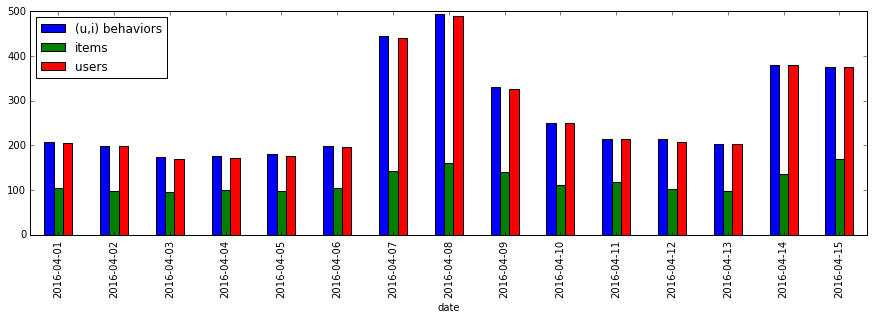

In [5]:
# 每个用户对商品子集的购买欲望不强，每个用户平均只会买一个
df.plot(kind='bar', figsize=(15, 4));
df.T

In [26]:
u['week'] = u.date.map(lambda d: dt.datetime.strptime(d, '%Y-%m-%d').strftime('%w'))

week,0,1,2,3,4,5,6
"(u,i) pairs",73454,71676,66843,66414,83915,120364,80894
user,20729,20184,18837,19167,23519,30809,22892
item,2386,2394,2381,2383,2402,2624,2395


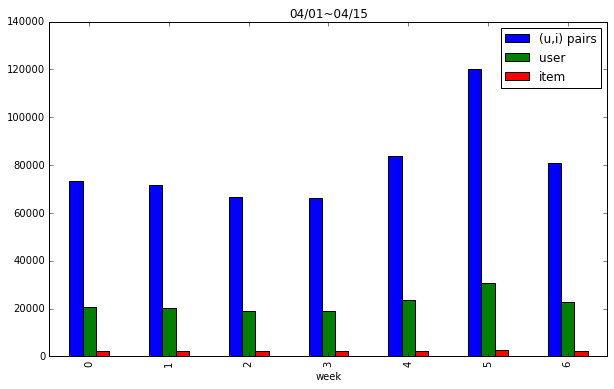

In [27]:
# 平均每个用户对很少的商品子集操作
df = u[u.type.lt(7) & u.date.lt('2016-04-16')].groupby(['week'])\
.apply(lambda df: pd.Series([
            len(df[['user_id', 'sku_id']].drop_duplicates()),
            len(df['user_id'].drop_duplicates()),
            len(df['sku_id'].drop_duplicates())
        ], index=['(u,i) pairs', 'user', 'item']))
df.plot(kind='bar', figsize=(10, 6), title="04/01~04/15");
df.T

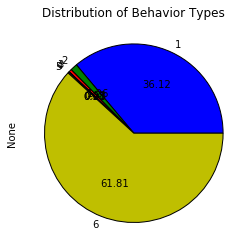

In [28]:
# 总的点击，浏览，收藏，加购，删除购物车，　下单的比例
u[u.date.lt('2016-04-16')].groupby('type').size().plot(kind='pie',autopct='%.2f',figsize=(4, 4),title="Distribution of Behavior Types",legend=False)

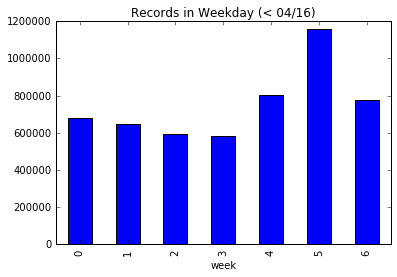

In [29]:
# 通常在星期五对商品子集的操作最多
u[u.date.lt('2016-04-16')].groupby('week').size().plot(kind='bar', title='Records in Weekday (< 04/16)')

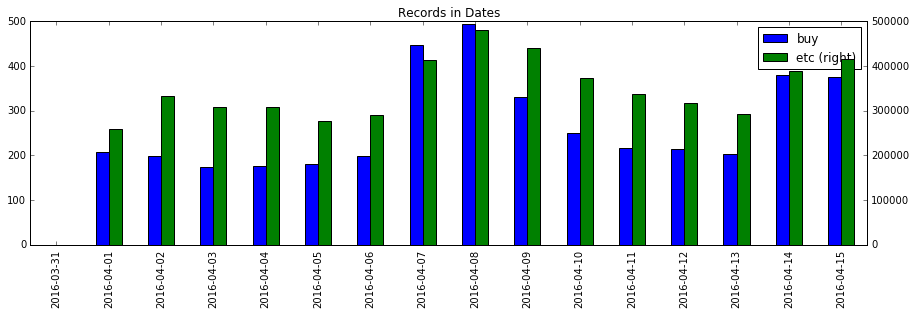

In [30]:
# 总的操作跟下单大致相当
pd.DataFrame(dict(
    buy=u[u.type.eq(4)].groupby('date').size(),
    etc=u[u.type.ne(4)].groupby('date').size()
)).plot(kind='bar', secondary_y=['etc'], title='Records in Dates', figsize=(15,4));

![Paste_Image.png](http://upload-images.jianshu.io/upload_images/1132123-ba462757349a7983.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

In [6]:
u.head()

,user_id,sku_id,type,item_category,date,hour
0,208266,31662,1,545,2016-03-31,23:59:04
1,209390,118799,6,244,2016-03-31,23:59:05
2,237311,5825,1,885,2016-03-31,23:59:05
3,297325,128747,6,489,2016-03-31,23:59:06
4,287896,68767,6,545,2016-03-31,23:59:07


In [8]:
u.columns = ['user_id','item_id','behavior_type','brand','date','hour']

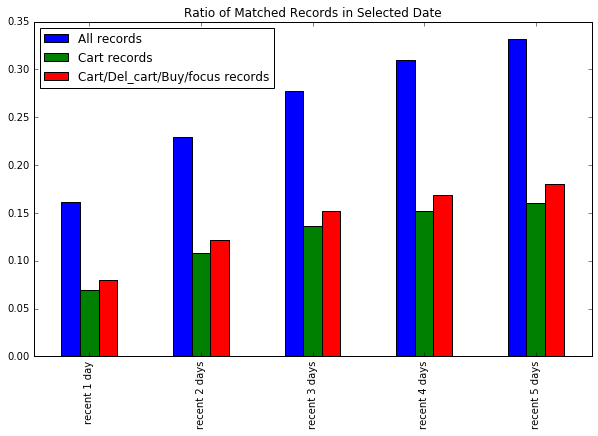

In [10]:
# 距离考察日之前的ui元组出现在考察日那一天的数量占考察日发生购买行为的ｕｉ的比例为多小
sel_ui = u[u.behavior_type.eq(4) & u.date.lt('2016-04-16')&u.date.ge('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id'])
pd.DataFrame({
    'recent 1 day': [
        sum(u[u.date.ge('2016-04-10') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-10') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-10') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui))
    ],
    'recent 2 days': [
        sum(u[u.date.ge('2016-04-09') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-09') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-09') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui))
    ],
    'recent 3 days': [
        sum(u[u.date.ge('2016-04-08') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-08') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-08') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) /float(len(sel_ui))
    ],
    'recent 4 days': [
        sum(u[u.date.ge('2016-04-07') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-07') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-07') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui))
    ],
    'recent 5 days': [
        sum(u[u.date.ge('2016-04-06') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-06') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui)),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-06') & u.date.lt('2016-04-11')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(sel_ui))
    ]
}, index=['All records', 'Cart records', 'Cart/Del_cart/Buy/focus records']).T.plot(kind='bar', title='Ratio of Matched Records in Selected Date', figsize=(10,6));

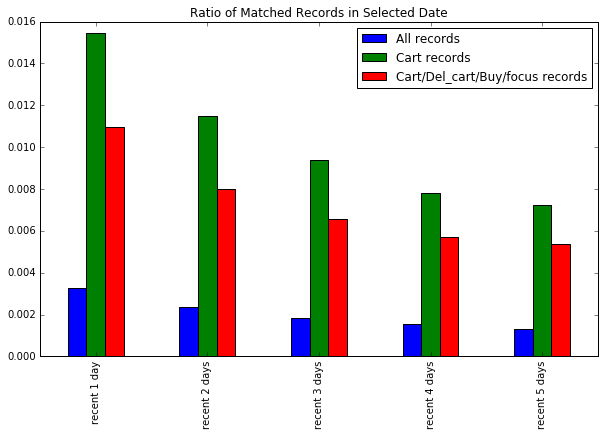

In [34]:
# 考察日之前浏览，收藏，加购的次数对应的在考察日的浏览，收藏，加购的比例为多小．算式: 考察日之前intersection(在考察日的) / 考察日之前
# ex:在考察日之前的10%的加购物车行为，转变成考察日的购买行为
sel_ui = u[u.behavior_type.eq(4) & u.date.eq('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id'])
pd.DataFrame({
    'recent 1 day': [
        sum(u[u.date.ge('2016-04-14') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.date.ge('2016-04-14') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-14') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.eq(2) & u.date.ge('2016-04-14') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-14') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-14') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates()))
    ],
    'recent 2 days': [
        sum(u[u.date.ge('2016-04-13') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.date.ge('2016-04-13') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-13') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.eq(2) & u.date.ge('2016-04-13') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-13') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-13') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates()))
    ],
    'recent 3 days': [
        sum(u[u.date.ge('2016-04-12') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.date.ge('2016-04-12') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-12') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.eq(2) & u.date.ge('2016-04-12') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-12') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) /float(len(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-12') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates()))
    ],
    'recent 4 days': [
        sum(u[u.date.ge('2016-04-11') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.date.ge('2016-04-11') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-11') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.eq(2) & u.date.ge('2016-04-11') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-11') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-11') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates()))
    ],
    'recent 5 days': [
        sum(u[u.date.ge('2016-04-10') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.date.ge('2016-04-10') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.eq(2) & u.date.ge('2016-04-10') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.eq(2) & u.date.ge('2016-04-10') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates())),
        sum(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-10') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates().set_index(['user_id', 'item_id']).index.isin(sel_ui.index)) / float(len(u[u.behavior_type.lt(6) & u.behavior_type.ge(2) & u.date.ge('2016-04-10') & u.date.lt('2016-04-15')][['user_id', 'item_id']].drop_duplicates()))
    ]
}, index=['All records', 'Cart records', 'Cart/Del_cart/Buy/focus records']).T.plot(kind='bar', title='Ratio of Matched Records in Selected Date', figsize=(10,6));

# 分析个人数据

In [51]:
udf = u.set_index(['user_id', 'item_id'])

In [53]:
u14 = udf[udf.behavior_type.eq(2) & udf.date.eq('2016-04-14')] # 14号加购物车

In [54]:
u15 = udf[udf.behavior_type.eq(4) & udf.date.eq('2016-04-15')] # 15号购买

In [111]:
# 未来7天
udf2 = u[u.date.lt('2016-04-15') & u.date.ge('2016-04-08')].set_index(['user_id', 'brand', 'item_id'])

In [107]:
udf = u.set_index(['user_id', 'brand', 'item_id'])

In [120]:
def inspect_user_behavior_percentage(user_id, cate, item_id = 0):
    # 考察日之前用户操作商品种类的数量和商品数量
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))
    udf2.loc[user_id, cate, :].sort_values(by=['date', 'hour']).reset_index().groupby('item_id').size().plot(kind = 'pie', ax= axes[0], autopct = '%.1f')
    udf2.loc[user_id, :, :].groupby(level = 0).size().plot(kind = 'pie', ax = axes[1], autopct = '%.1f')
    return udf2[udf2.behavior_type == 2].loc[user_id, :, :].sort_values(by = ['date', 'hour'])

In [108]:
# 历史购物车是否有此类商品
u15[~u15.index.isin(u14.index)] # 除了14号加购物车，15号购买之外的在15号人

,,no,model_id,behavior_type,cate,brand,date,hour,week
user_id,item_id,,,,,,,,
77249,154636,18237117,NaN,4,8,545,2016-04-15,16:22:00,5
45064,154636,18241896,NaN,4,8,545,2016-04-15,12:17:00,5
3890,14433,18247818,NaN,4,8,30,2016-04-15,07:20:00,5
57797,14433,18248067,NaN,4,8,30,2016-04-15,14:28:00,5
39350,50482,18255660,NaN,4,8,489,2016-04-15,05:06:00,5
13220,16839,18259184,NaN,4,8,214,2016-04-15,16:03:00,5
70695,125756,18260204,NaN,4,8,30,2016-04-15,21:22:00,5
65360,125756,18262164,NaN,4,8,30,2016-04-15,20:00:00,5
10010,16839,18262215,NaN,4,8,214,2016-04-15,14:50:00,5


,,no,model_id,behavior_type,cate,date,hour,week
brand,item_id,,,,,,,
545,42199,15493443,NaN,2,8,2016-04-13,17:40:22,3
30,14433,15405565,NaN,2,8,2016-04-13,17:41:28,3
545,154636,15558689,NaN,2,8,2016-04-13,17:43:15,3


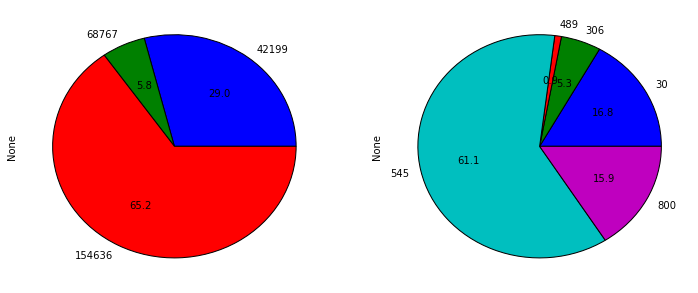

In [128]:
inspect_user_behavior_percentage(3151, 545, 154636)

In [104]:
u14[u14.index.isin(u15.index)] # 14号加购物车，15号购买u的

no  model_id  behavior_type  cate  brand        date  \
user_id item_id                                                               
52919   166707   16562067       NaN              2     8    489  2016-04-14   
60244   64794    16564363       NaN              2     8     30  2016-04-14   
63645   151327   16582605       NaN              2     8    403  2016-04-14   
92794   149641   16606067       NaN              2     8    403  2016-04-14   
34266   79636    16625189       NaN              2     8    489  2016-04-14   
        79636    16625190       NaN              2     8    489  2016-04-14   
49135   78694    16626547       NaN              2     8    244  2016-04-14   
74231   84389    16628975       NaN              2     8    489  2016-04-14   
58721   84389    16632063       NaN              2     8    489  2016-04-14   
6520    145946   16712034       NaN              2     8    658  2016-04-14   
15883   145946   16712137       NaN              2     8    658  2016-04-14   
8804    69355    16764033       NaN              2     8    800  2016-04-14   
59418   37957    16767441       NaN              2     8    489  2016-04-14   
33619   1628     16768456       NaN              2     8    214  2016-04-14   
57019   11090    16772553       NaN              2     8    214  2016-04-14   
89709   117452   16794258       NaN              2     8    677  2016-04-14   
20962   117452   16795788       NaN              2     8    677  2016-04-14   
60721   116489   16797587       NaN              2     8    545  2016-04-14   
9653    158013   16806034       NaN              2     8    214  2016-04-14   
        158013   16806041       NaN              2     8    214  2016-04-14   
84585   12540    16809220       NaN              2     8    545  2016-04-14   
79526   103014   16833860       NaN              2     8    800  2016-04-14   
100786  131300   16843146       NaN              2     8    693  2016-04-14   
        131300   16843148       NaN              2     8    693  2016-04-14   
46877   138151   16860308       NaN              2     8     30  2016-04-14   
        138151   16860309       NaN              2     8     30  2016-04-14   
44604   138151   16861505       NaN              2     8     30  2016-04-14   
71669   36748    16865476       NaN              2     8    427  2016-04-14   
33588   115867   16871005       NaN              2     8    489  2016-04-14   
93795   62351    16879390       NaN              2     8    306  2016-04-14   
...                   ...       ...            ...   ...    ...         ...   
12806   160476   17056549       NaN              2     8    545  2016-04-14   
        160476   17056550       NaN              2     8    545  2016-04-14   
        160476   17056552       NaN              2     8    545  2016-04-14   
31082   63006    17081579       NaN              2     8    214  2016-04-14   
38761   61531    17081656       NaN              2     8    214  2016-04-14   
        61531    17081657       NaN              2     8    214  2016-04-14   
95452   12564    17085016       NaN              2     8    214  2016-04-14   
        12564    17085017       NaN              2     8    214  2016-04-14   
        12564    17085018       NaN              2     8    214  2016-04-14   
        12564    17085019       NaN              2     8    214  2016-04-14   
58574   89802    17085801       NaN              2     8    545  2016-04-14   
33436   21147    17089218       NaN              2     8    403  2016-04-14   
2415    12564    17091085       NaN              2     8    214  2016-04-14   
        12564    17091086       NaN              2     8    214  2016-04-14   
        12564    17091087       NaN              2     8    214  2016-04-14   
83313   18412    17098660       NaN              2     8    214  2016-04-14   
59597   152872   17116720       NaN              2     8    306  2016-04-14   
30522   128747   17130916       NaN              2     8    489  2016-04-

no  model_id  behavior_type  cate        date      hour  \
brand item_id                                                                  
489   37957    11728960       NaN              2     8  2016-04-10  17:28:06   
      37957    16767441       NaN              2     8  2016-04-14  14:40:33   

              week  
brand item_id       
489   37957      0  
      37957      4

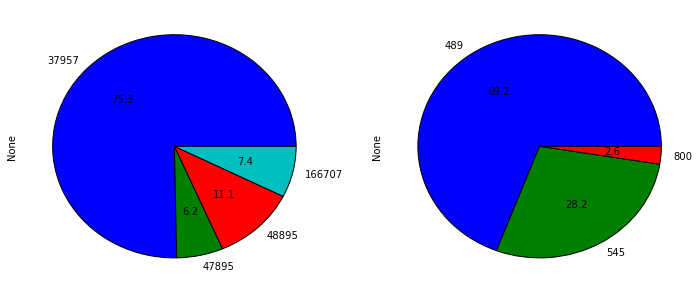

In [129]:
# 当天加购，对后一天的影响
inspect_user_behavior_percentage(59418, 489, 37957)

In [131]:
d = u[u.date.lt('2016-04-15') & u.date.ge('2016-04-10')] # 14, 13, 12, 11,10 

In [139]:
user_last_cart_hour = d[d.behavior_type == 2].groupby('user_id').date.last()

In [146]:
user_cnt = d.groupby('user_id').behavior_type.sum().reset_index()
user_cnt.columns = pd.Index(['user_id', 'user_cnt'])

user_item_cnt = d.groupby(['user_id', 'item_id']).agg(dict(behavior_type='sum', brand='first')).reset_index()
user_item_cnt.columns = pd.Index(['user_id', 'item_id', 'item_cnt', 'item_category'])

user_category_cnt = d.groupby(['user_id', 'brand']).behavior_type.sum().reset_index()
user_category_cnt.columns = pd.Index(['user_id', 'item_category', 'category_cnt'])

In [149]:
usm = pd.merge(
    user_cnt,
    pd.merge(
        user_item_cnt,
        user_category_cnt,
        on=['user_id', 'item_category'], how='left'
    ),
    on='user_id'
)
usm['category_user_pcn'] = usm['category_cnt'] / usm['user_cnt']
usm['item_category_pcn'] = usm['item_cnt'] / usm['category_cnt']
usm['item_user_pcn'] = usm['item_cnt'] / usm['user_cnt']

In [150]:
usm

,user_id,user_cnt,item_id,item_cnt,item_category,category_cnt,category_user_pcn,item_category_pcn,item_user_pcn
0,1,76,124997,76,693,76,1.000000,1.000000,1.000000
1,8,6,96887,6,214,6,1.000000,1.000000,1.000000
2,11,90,52343,32,489,32,0.355556,1.000000,0.355556
3,11,90,57018,58,545,58,0.644444,1.000000,0.644444
4,15,90,18412,90,214,90,1.000000,1.000000,1.000000
5,17,109,285,13,214,71,0.651376,0.183099,0.119266
6,17,109,21457,13,214,71,0.651376,0.183099,0.119266
7,17,109,58959,38,622,38,0.348624,1.000000,0.348624
8,17,109,60077,13,214,71,0.651376,0.183099,0.119266
9,17,109,65428,13,214,71,0.651376,0.183099,0.119266


In [11]:
u.head()

,user_id,item_id,behavior_type,brand,date,hour
0,208266,31662,1,545,2016-03-31,23:59:04
1,209390,118799,6,244,2016-03-31,23:59:05
2,237311,5825,1,885,2016-03-31,23:59:05
3,297325,128747,6,489,2016-03-31,23:59:06
4,287896,68767,6,545,2016-03-31,23:59:07


In [17]:
check_day = u[u.date.ge('2016-04-11')&u.date.lt('2016-04-16')&u.behavior_type.eq(4)].user_id

In [28]:
check_day_no = u[u.date.ge('2016-04-11')&u.date.lt('2016-04-16')&u.behavior_type.ne(4)].user_id

In [25]:
before_day = u[u.date.lt('2016-04-11')&u.date.ge('2016-04-03')].user_id.isin(check_day) # 在后五天有购买的用户

In [29]:
before_info = u[u.date.lt('2016-04-11')&u.date.ge('2016-04-03')]

In [30]:
act =pd.get_dummies(before_info.behavior_type,prefix='action')

In [33]:
all = pd.concat([before_info, act], axis=1)

In [42]:
buy = all[before_day].groupby(['user_id']).sum()

In [43]:
浏览,加入购物车，购物车删除，下单，关注，点击

SyntaxError: invalid syntax (<ipython-input-43-f66e6bbbf2be>, line 1)

In [44]:
buy.iloc[50:70]

,item_id,behavior_type,brand,action_1,action_2,action_3,action_4,action_5,action_6
user_id,,,,,,,,,
206931,1741136,56,6072,8.0,0.0,0.0,0.0,0.0,8.0
206951,3383382,175,24464,19.0,0.0,0.0,0.0,0.0,26.0
206991,1538122,54,420,6.0,0.0,0.0,0.0,0.0,8.0
207052,2752552,167,20165,7.0,5.0,0.0,0.0,0.0,25.0
207056,15981048,618,66382,55.0,1.0,0.0,0.0,3.0,91.0
207060,1214532,53,8802,11.0,0.0,0.0,0.0,0.0,7.0
207077,31662,1,545,1.0,0.0,0.0,0.0,0.0,0.0
207106,5825,1,885,1.0,0.0,0.0,0.0,0.0,0.0
207143,32207587,969,148598,122.0,10.0,0.0,0.0,1.0,137.0


In [45]:
no_buy = all[~before_day].groupby(['user_id']).sum()

In [51]:
no_buy.drop(['item_id','behavior_type','brand'], axis = 1,inplace=True)

In [54]:
no_buy.columns = ['浏览','加入购物车','购物车删除','下单','关注','点击']

In [62]:
??pd.Series.sort_values

In [63]:
no_buy['浏览'].sort_values(ascending=False)

user_id
293215    1481.0
247006     914.0
291207     826.0
231288     783.0
209147     782.0
258626     772.0
227874     738.0
214315     729.0
258487     712.0
284730     709.0
271506     708.0
223340     646.0
274217     644.0
267848     637.0
212356     626.0
213006     578.0
229039     576.0
295193     576.0
257176     572.0
207069     530.0
293301     524.0
280079     518.0
211094     518.0
214658     516.0
261135     507.0
223181     505.0
217174     504.0
259211     494.0
216146     492.0
239431     487.0
           ...  
271993       0.0
212489       0.0
212488       0.0
245483       0.0
271980       0.0
212471       0.0
291142       0.0
271959       0.0
291167       0.0
291180       0.0
231556       0.0
271790       0.0
245445       0.0
245429       0.0
212390       0.0
212378       0.0
271740       0.0
212358       0.0
212335       0.0
271690       0.0
231707       0.0
257939       0.0
231714       0.0
231730       0.0
212283       0.0
245357       0.0
271666       0.0
258000

In [57]:
no_buy[no_buy['浏览'] == 1481]

,浏览,加入购物车,购物车删除,下单,关注,点击
user_id,,,,,,
293215,1481.0,6.0,4.0,0.0,11.0,2362.0


In [49]:
no_buy.mean()

item_id          4.964822e+06
behavior_type    2.429730e+02
brand            2.619873e+04
action_1         2.153418e+01
action_2         7.536129e-01
action_3         3.048430e-01
action_4         4.715062e-02
action_5         1.232250e-01
action_6         3.636873e+01
dtype: float64

In [50]:
7.536129e-01

0.7536129